In [41]:
# Mount Google Drive containing data
from google.colab import drive
drive.mount('/content/drive')
datadir = '/content/drive/My Drive/IE 534/Deep Dive Project - Energy Prices in Illinois/Data/'

def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_pickle(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pd.read_pickle(loc,**kwargs)
    return out


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
%pwd

'/content'

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random

In [44]:
# Function to generate a random color
def random_color():
  return (random.random(), random.random(), random.random())

In [45]:

all_data=getfile(("all_data.pkl","https://drive.google.com/file/d/1xG-ruT7PqEXD10Hksqn9EJfWvoHTuodB/view?usp=drive_link"))
debugging=getfile(("debugging.pkl","https://drive.google.com/file/d/11t5lDtIHSUe_aIGci137QTw-wvuRjuhu/view?usp=drive_link"))
working=getfile(("working.pkl","https://drive.google.com/file/d/18QrPq8LNeUwSLzJf-o5wbLLF2QcThUpT/view?usp=drive_link"))

local file not found; accessing Google Drive
local file not found; accessing Google Drive
local file not found; accessing Google Drive


Below we print the first few items from the dataset (this dataset includes all of the data). In the milestone 1 notebook, we took raw CSV files and combined them into one single dataset. Additionally, as you can see below, we created the following features (which are shown as columns):   

-Forecast energy load for Illinois

-Predicted next day energy price for Illinois

-Finally, we have actual energy price from the surrounding state. The surrounding states are listed next.

Each sample is a unique sample in the time series.


In [46]:
all_data.head(8)

,Date,Forecasted Load (MISO),Day Ahead Energy Price (IL),Energy Price (IL),Sin_Month,Cos_Month,Sin_Day,Cos_Day,Sin_Hour,Cos_Hour,Energy Price (MICHIGAN.HUB),Energy Price (MINN.HUB),Energy Price (INDIANA.HUB),Energy Price (TEXAS.HUB),Energy Price (LOUISIANA.HUB),Energy Price (ARKANSAS.HUB),Energy Price (MS.HUB),Temperature
0,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,0.022539,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337
1,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,0.022539,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337
2,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,0.022539,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337
3,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,0.022539,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337
4,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,0.022539,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337
5,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,0.022539,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337
6,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,0.022539,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337
7,2018-01-23 10:00:00,0.445752,0.083852,0.043310,0.75,0.933013,1.0,0.75,0.699666,0.036909,0.023037,0.045275,0.014116,0.030578,0.057732,0.030063,0.037346,0.454819


Below are the Hubs. There are 9 hubs, not including NaN.

In [47]:
unique_values_mi = all_data["Energy Price (MICHIGAN.HUB)"].unique()
unique_values_mn = all_data["Energy Price (MINN.HUB)"].unique()
unique_values_in = all_data["Energy Price (INDIANA.HUB)"].unique()
unique_values_tx = all_data["Energy Price (TEXAS.HUB)"].unique()
unique_values_la = all_data["Energy Price (LOUISIANA.HUB)"].unique()
unique_values_ar = all_data["Energy Price (ARKANSAS.HUB)"].unique()
unique_values_ms = all_data["Energy Price (MS.HUB)"].unique()

print(f"Number of unique values in MICHIGAN.HUB = {len(unique_values_mi)}")
print(unique_values_mi)
print(f"Number of unique values in MINN.HUB = {len(unique_values_mn)}")
print(unique_values_mn)
print(f"Number of unique values in INDIANA.HUB = {len(unique_values_in)}")
print(unique_values_in)
print(f"Number of unique values in TEXAS.HUB = {len(unique_values_tx)}")
print(unique_values_tx)
print(f"Number of unique values in LOUISIANA.HUB = {len(unique_values_la)}")
print(unique_values_la)
print(f"Number of unique values in ARKANSAS.HUB = {len(unique_values_ar)}")
print(unique_values_ar)
print(f"Number of unique values in MS.HUB = {len(unique_values_ms)}")
print(unique_values_ms)

Number of unique values in MICHIGAN.HUB = 7969
[0.02253868 0.02303674 0.02354347 ... 0.03023058 0.02945533 0.06069504]
Number of unique values in MINN.HUB = 8021
[0.04488466 0.0452751  0.04611564 ... 0.07303992 0.09626043 0.05766624]
Number of unique values in INDIANA.HUB = 8403
[0.01313714 0.01411592 0.01506166 ... 0.02188008 0.05059099 0.02159512]
Number of unique values in TEXAS.HUB = 7564
[0.02947227 0.03057758 0.03085112 ... 0.02699647 0.02620936 0.03761419]
Number of unique values in LOUISIANA.HUB = 7589
[0.05695346 0.0577319  0.05800042 ... 0.07228354 0.05451236 0.0642442 ]
Number of unique values in ARKANSAS.HUB = 7287
[0.02935853 0.03006289 0.030293   ... 0.04179844 0.03466787 0.02630538]
Number of unique values in MS.HUB = 7502
[0.03671715 0.03734595 0.03758141 ... 0.04660626 0.03415484 0.03417977]


Next, we have to add some features from the time. Below we had the month, day of week, and the hour as features.

In [48]:

# Create new columns for month, day of the week, and hour
all_data['Month']       = all_data['Date'].dt.month
all_data['Day of week'] = all_data['Date'].dt.day_name()
all_data['Hour']        = all_data['Date'].dt.hour

all_data.head(8)


,Date,Forecasted Load (MISO),Day Ahead Energy Price (IL),Energy Price (IL),Sin_Month,Cos_Month,Sin_Day,Cos_Day,Sin_Hour,Cos_Hour,...,Energy Price (MINN.HUB),Energy Price (INDIANA.HUB),Energy Price (TEXAS.HUB),Energy Price (LOUISIANA.HUB),Energy Price (ARKANSAS.HUB),Energy Price (MS.HUB),Temperature,Month,Day of week,Hour
0,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,...,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337,12,Monday,12
1,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,...,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337,12,Monday,12
2,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,...,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337,12,Monday,12
3,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,...,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337,12,Monday,12
4,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,...,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337,12,Monday,12
5,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,...,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337,12,Monday,12
6,2017-12-04 12:00:00,0.332677,0.076424,0.042684,0.50,1.000000,0.5,1.00,0.431758,0.000000,...,0.044885,0.013137,0.029472,0.056953,0.029359,0.036717,0.709337,12,Monday,12
7,2018-01-23 10:00:00,0.445752,0.083852,0.043310,0.75,0.933013,1.0,0.75,0.699666,0.036909,...,0.045275,0.014116,0.030578,0.057732,0.030063,0.037346,0.454819,1,Tuesday,10


Below is some info about the data. The data is stored as a Pandas dataframe. We can also see the number of samples is 723840  (before any filtering). Note, there are many NaN. The time frame of the actual energy prices for the various states has a much larger time frame. See below for the number values that are non-NaN and the number of NaN for each feature.

In [49]:
print("Info about dataset\n\n")
print(all_data.info())

print("\n\nNumber of NaN for each feature\n\n")
print(all_data.isna().sum())


Info about dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228830 entries, 0 to 228829
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Date                          228830 non-null  datetime64[ns]
 1   Forecasted Load (MISO)        228830 non-null  float64       
 2   Day Ahead Energy Price (IL)   228830 non-null  float64       
 3   Energy Price (IL)             228830 non-null  float64       
 4   Sin_Month                     228830 non-null  float64       
 5   Cos_Month                     228830 non-null  float64       
 6   Sin_Day                       228830 non-null  float64       
 7   Cos_Day                       228830 non-null  float64       
 8   Sin_Hour                      228830 non-null  float64       
 9   Cos_Hour                      228830 non-null  float64       
 10  Energy Price (MICHIGAN.HUB)   228830 non-null  float64     

We see below some descriptive stats about the data. Day ahead energy price and the actual energy prices all have a mean about 30 LMP. An LMP unit is locational marginal price which is "the marginal price for energy at the location where the energy is delivered or received and is based on forecasted system conditions and the latest approved real-time security constrained economic dispatch program solution" (https://www.pjm.com/-/media/committees-groups/committees/mic/2020/20200825-five-minute/20200825-item-05a-m11-redlines.ashx).

In [50]:
print(f"Descriptive stats:\n{all_data.describe()}")

Descriptive stats:
                                Date  Forecasted Load (MISO)  \
count                         228830           228830.000000   
mean   2021-03-12 12:02:15.454266880                0.338071   
min              2017-12-04 12:00:00                0.000000   
25%              2019-06-26 02:00:00                0.231381   
50%              2021-08-09 14:30:00                0.314166   
75%              2022-09-16 08:00:00                0.417457   
max              2023-09-30 22:00:00                1.000000   
std                              NaN                0.154037   

       Day Ahead Energy Price (IL)  Energy Price (IL)      Sin_Month  \
count                228830.000000      228830.000000  228830.000000   
mean                      0.111416           0.049935       0.486423   
min                       0.000000           0.000000       0.000000   
25%                       0.075917           0.042840       0.066987   
50%                       0.092318          

Next, in the plots below, we can see the value of the actual energy price over time for Illinois and compare it to all the other hubs. We can see that for Illinois and the surrounding states, there a few outliers that dominate the graph. For example, for the Illinois hub, we can see that from 2009 to 2013 there were a few periods that had significantly low energy prices. Negative LMP values can occur when "there is too much supply but not enough demand in a given region" (https://essinc.com/u-s-power-generators-grapple-with-negative-pricing-long-duration-energy-storage-can-help/#:~:text=However%2C%20periods%20of%20%E2%80%9Cnegative%20pricing,customers%20to%20take%20their%20power). Looking at the descriptive stats above, we can see that the minimum value of Illinois' actual energy price is negative 75145 LMP. We can also see in the graphs below that there are gaps in the data. For example, for Illinois there is a gap in the data between 2020 and 2022. The gap in the data is also seen for the other states.

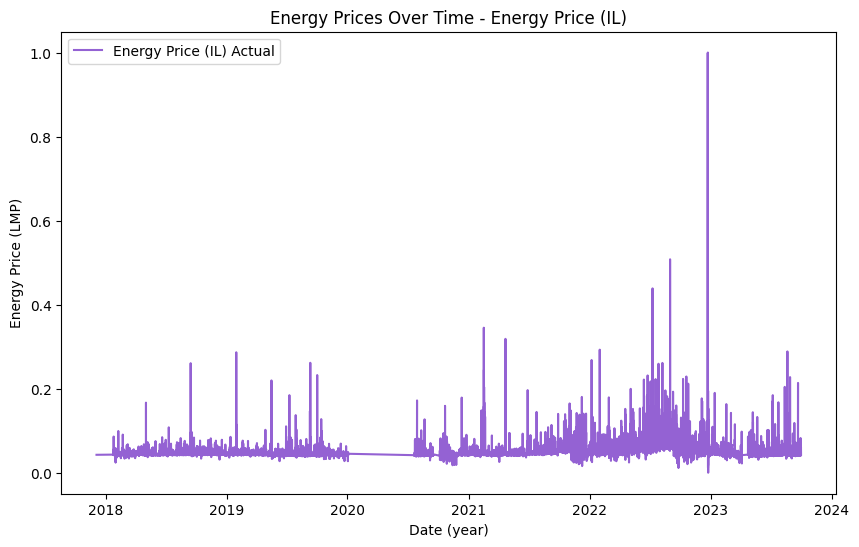

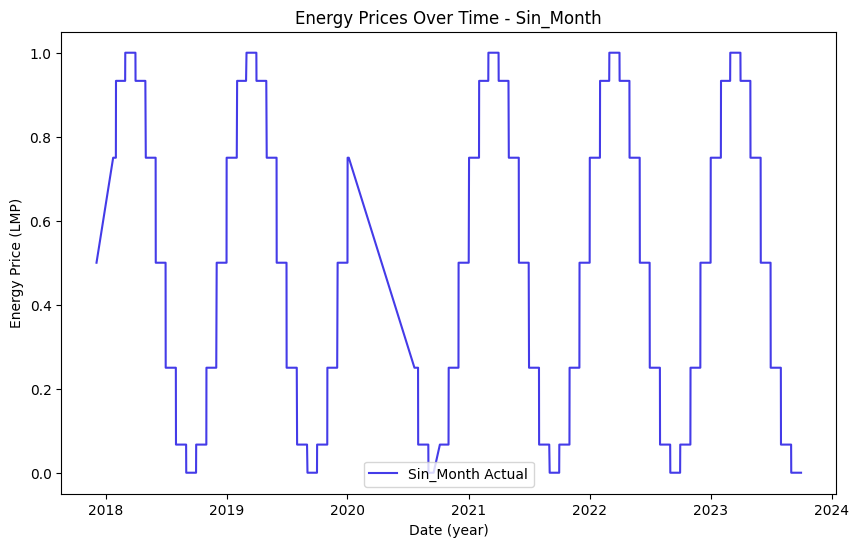

In [51]:
for feature in all_data.columns[3:5]:
  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot lines for each state
  ax.plot(all_data['Date'], all_data[feature], label=f'{feature} Actual', color=random_color())

  # Set title and labels
  ax.set_title(f'Energy Prices Over Time - {feature}')
  ax.set_xlabel('Date (year)')
  ax.set_ylabel('Energy Price (LMP)')

  # Add legend
  ax.legend()

  # Show plot
  plt.show()

The graph above, we included all of the non-Illinois states in one plot. Below, we can see each state individually. We can see that each state has actual energy prices are quite different than Illinois. We will discuss the time periods of the data next.



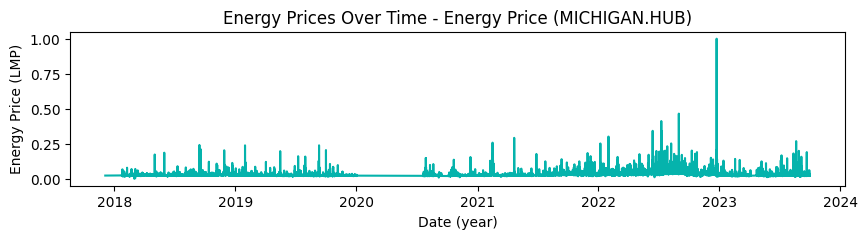

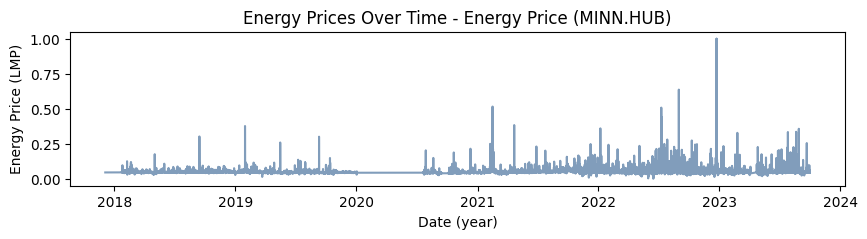

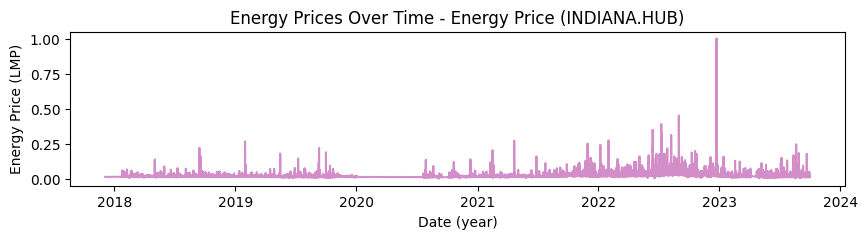

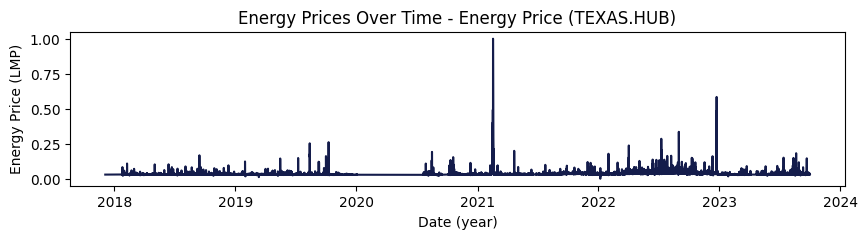

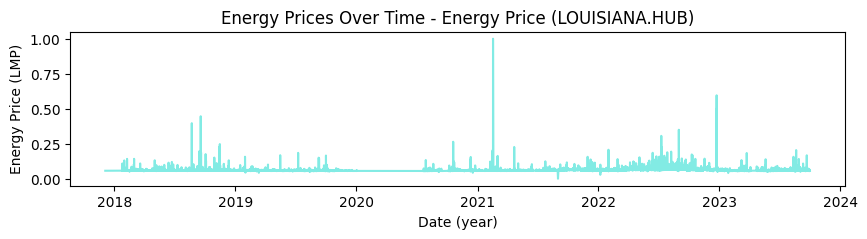

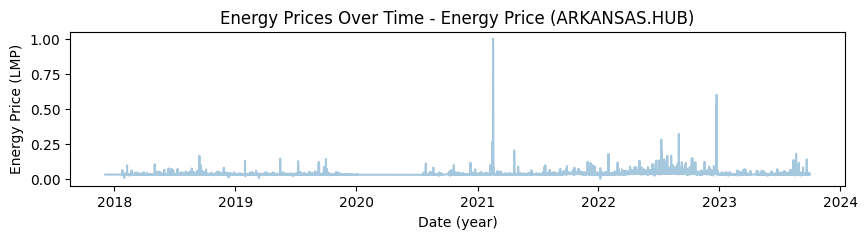

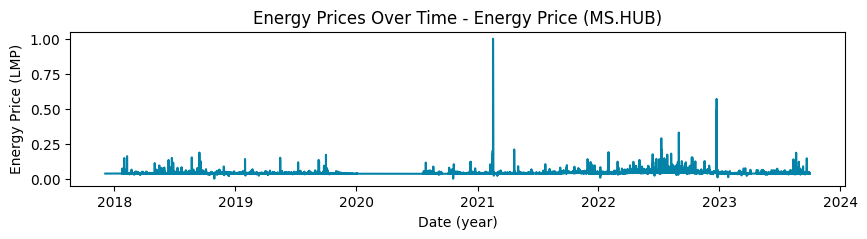

In [52]:
# def plot_data(x, y, hub):
#   # Create a figure and axis
#   fig, ax = plt.subplots(figsize=(10, 2))

#   # Plot lines for each state
#   ax.plot(x, y, label=f'{hub}', color=random_color())

#   # Set title and labels
#   ax.set_title(f'Energy Prices Over Time - {hub}')
#   ax.set_xlabel('Date (year)')
#   ax.set_ylabel('Energy Price (LMP)')

#   # Show plot
#   plt.show()

# feature = all_data[['Date', 'HUB', 'Actual Energy Price (others)']].dropna()

# # print(feature.head())
# hubs = feature[feature['HUB'] != 'ILLINOIS.HUB']['HUB'].unique().tolist()
# for hub in hubs:
#   feature_hub = feature[feature['HUB'] == hub]
#   plot_data(feature_hub['Date'], feature_hub['Actual Energy Price (others)'], hub)
def plot_data(x, y, hub):
  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(10, 2))

  # Plot lines for each state
  ax.plot(x, y, label=f'{hub}', color=random_color())

  # Set title and labels
  ax.set_title(f'Energy Prices Over Time - {hub}')
  ax.set_xlabel('Date (year)')
  ax.set_ylabel('Energy Price (LMP)')

  # Show plot
  plt.show()

feature = all_data[['Date',
                    'Energy Price (MICHIGAN.HUB)',
                    'Energy Price (MINN.HUB)',
                    'Energy Price (INDIANA.HUB)',
                    'Energy Price (TEXAS.HUB)',
                    'Energy Price (LOUISIANA.HUB)',
                    'Energy Price (ARKANSAS.HUB)',
                    'Energy Price (MS.HUB)'
                    ]].dropna()

hubs = feature.columns.tolist()[1:]  # Get the list of hub columns

for hub in hubs:
  feature_hub = feature[['Date', hub]]  # Select the Date and current hub columns
  plot_data(feature_hub['Date'], feature_hub[hub], hub)

Next, after dropping all NaN, we look at the date range of the actual energy prices. As we can see below the actual energy price for Illinois spans from 2006 to 2024. But, for the other states energy prices, there isn't a similar constant date range which we will see next.

In [53]:
print("Last recorded values:")
for col in all_data.columns[3:-1]:
  feature = all_data[['Date', col]].dropna()
  start_date = feature['Date'].min()
  end_date = feature['Date'].max()
  # Format the dates to show only month and year
  start_month_year = start_date.strftime('%B %Y')
  end_month_year = end_date.strftime('%B %Y')
  print(f"Date range for {col}:")
  print("Start date:", start_month_year)
  print("End date:", end_month_year)

Last recorded values:
Date range for Energy Price (IL):
Start date: December 2017
End date: September 2023
Date range for Sin_Month:
Start date: December 2017
End date: September 2023
Date range for Cos_Month:
Start date: December 2017
End date: September 2023
Date range for Sin_Day:
Start date: December 2017
End date: September 2023
Date range for Cos_Day:
Start date: December 2017
End date: September 2023
Date range for Sin_Hour:
Start date: December 2017
End date: September 2023
Date range for Cos_Hour:
Start date: December 2017
End date: September 2023
Date range for Energy Price (MICHIGAN.HUB):
Start date: December 2017
End date: September 2023
Date range for Energy Price (MINN.HUB):
Start date: December 2017
End date: September 2023
Date range for Energy Price (INDIANA.HUB):
Start date: December 2017
End date: September 2023
Date range for Energy Price (TEXAS.HUB):
Start date: December 2017
End date: September 2023
Date range for Energy Price (LOUISIANA.HUB):
Start date: December

As we can see below, each state has different date ranges after dropping NaN. Cinergy and FE only ran from 2006 to 2011. Indiana started in 2011. Michigan and Minnesota spanned 2006 to 2024 like Illinois. Texas, Arkansas, and Louisiana all spanned 2013 to 2024. Finally, Mississippi has the smallest date range from 2017 to 2024. Since the date range isn't consistent, it isn't a good idea to simply create 9 more features. It would create a very sparse data set since Cinergy and FE only have data from 2006 to 2011. Therefore, we need to be smart when using the data. We know there is issues with the data because there are some gaps in the data. As we can see next, even though some of the data extends back to 2006, not all of our features extend that far back.

In [54]:
# col = all_data.columns[5]
# feature = all_data[['Date', col]].dropna()
# hubs = feature[feature[col] != 'ILLINOIS.HUB'][col].unique().tolist()
# for hub in hubs:
#   feature_hub = feature[feature['HUB'] == hub]
#   start_date = feature_hub['Date'].min()
#   end_date = feature_hub['Date'].max()
#   # Format the dates to show only month and year
#   start_month_year = start_date.strftime('%B %Y')
#   end_month_year = end_date.strftime('%B %Y')
#   print(f"Date range for {hub}:")
#   print("Start date:", start_month_year)
#   print("End date:", end_month_year)
col = all_data.columns[5]
feature = all_data[['Date', col]].dropna()
hubs = feature[col].unique().tolist()
for hub in hubs:
  feature_hub = feature[feature[col] == hub]
  start_date = feature_hub['Date'].min()
  end_date = feature_hub['Date'].max()
  # Format the dates to show only month and year
  start_month_year = start_date.strftime('%B %Y')
  end_month_year = end_date.strftime('%B %Y')
  print(f"Date range for {hub}:")
  print("Start date:", start_month_year)
  print("End date:", end_month_year)

Date range for 1.0:
Start date: December 2017
End date: December 2022
Date range for 0.9330127018922194:
Start date: January 2018
End date: January 2023
Date range for 0.75:
Start date: February 2018
End date: February 2023
Date range for 0.5:
Start date: March 2018
End date: March 2023
Date range for 0.2500000000000001:
Start date: April 2018
End date: April 2023
Date range for 0.06698729810778065:
Start date: May 2018
End date: May 2023
Date range for 0.0:
Start date: June 2018
End date: June 2023
Date range for 0.06698729810778059:
Start date: July 2018
End date: July 2023
Date range for 0.24999999999999978:
Start date: August 2018
End date: August 2023
Date range for 0.4999999999999999:
Start date: September 2018
End date: September 2023
Date range for 0.9330127018922192:
Start date: November 2018
End date: November 2022


Below, we plot the other features such as forecasted load (in megawatts) and the day ahead energy price (in LMP) for Illinois. We can see issues in the features because there is a gap in forecasted load in 2020. This issue will need to be resolved because if we keep all of the features above (actual energy prices from surrounding states) and the features below, we will have spare data with many NaN. Therefore, since date range for Day Ahead Energy Price (for Illinois) only spans from 2014 to 2024, there is no point to keep the actual energy prices from before 2014. Additionally, since Forecasted Load (for Illinois) extends from 2017 to 2024, we would need to drop any data from before 2017. This is assuming that all features are important. It may turn out that Forecasted Load doesn't help predict the actual energy prices for Illinois at all. If that were the case, then we could keep all of the data from 2006 and onward. This will be discovered during testing.



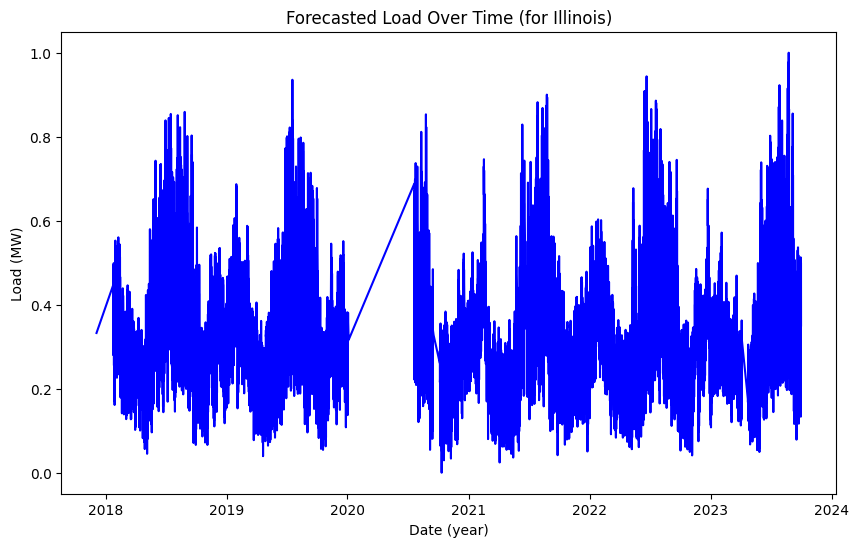

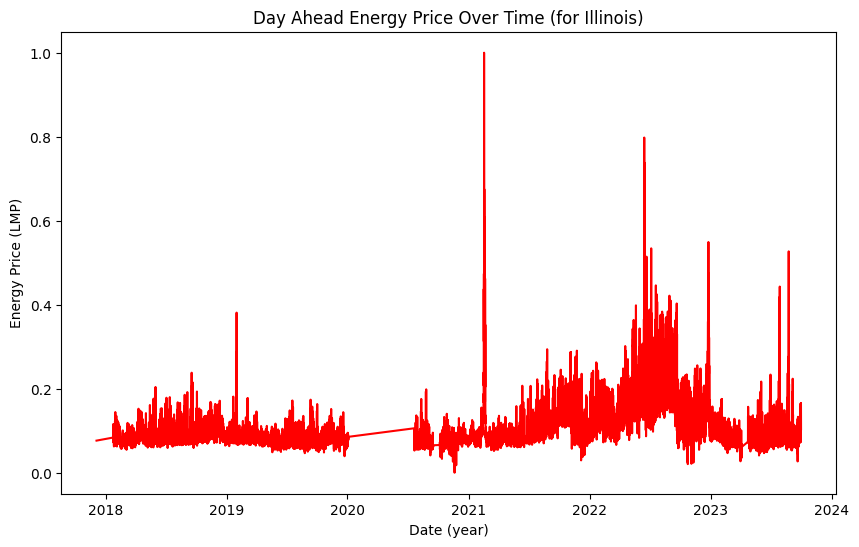

In [55]:
# Create a figure for forcasted load
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lines for each state
ax.plot(all_data['Date'], all_data[all_data.columns[1]], color='blue')

# Set title and labels
ax.set_title("Forecasted Load Over Time (for Illinois)")
ax.set_xlabel('Date (year)')
ax.set_ylabel('Load (MW)')

# Show plot
plt.show()

# Create a figure for
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lines for each state
ax.plot(all_data['Date'], all_data[all_data.columns[2]], color='red')

# Set title and labels
ax.set_title("Day Ahead Energy Price Over Time (for Illinois)")
ax.set_xlabel('Date (year)')
ax.set_ylabel('Energy Price (LMP)')

# Show plot
plt.show()

In [56]:
print("Last recorded values:")
for col in all_data.columns[1:3]:
  feature = all_data[['Date', col]].dropna()
  start_date = feature['Date'].min()
  end_date = feature['Date'].max()
  # Format the dates to show only month and year
  start_month_year = start_date.strftime('%B %Y')
  end_month_year = end_date.strftime('%B %Y')
  print(f"Date range for {col}:")
  print("Start date:", start_month_year)
  print("End date:", end_month_year)

Last recorded values:
Date range for Forecasted Load (MISO):
Start date: December 2017
End date: September 2023
Date range for Day Ahead Energy Price (IL):
Start date: December 2017
End date: September 2023


In conclusion, we can see that our data isn't perfect. There are major gaps in the data. Some Hubs like CINERGY and FE only had data until 2011. Some features, like forecasted load, only have data from 2017 to 2024. Therefore, the features must be tested in order to see feature importance. There isn't a clear way to merge the data since some features have short date ranges (like forecasted load) whereas our ground truth (actual energy cost for Illinois) spans a much larger range. We do know that there is a gap in the data for the ground truth around 2021. Thus, we must drop any date range which doesn't have a corresponding ground truth. This is obvious. What is not so obvious is what features are the most important? Each feature has different date ranges, so we want to be sure to keep the date range of the most important feature.